# Experimenting with low-rank model compression
## this time with vision transformers 

In [1]:
import os
import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
import time
from copy import deepcopy as copy

from sklearn.cluster import AgglomerativeClustering
import numpy as np

from tqdm import tqdm
import time 
import gc

from copy import deepcopy as copy
import time


def dino_model():
    os.environ['TORCH_HOME'] = './'
    os.environ['TORCH_HUB'] = './'
    # DINOv2 vit-s (14) with registers
    # model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
    # state = model.state_dict()
    # mymodel = vit_small(14, 4)
    # mymodel.load_state_dict(state)
    model.eval()

    return model.to('cpu')

def dino_transforms():
    return v2.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        transforms.Resize(size=(256, 256), antialias=True),
                        transforms.CenterCrop((224, 224)),
                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]
                                            ),
                    ]
                    )

DINOv2 = dino_model()
DINOv2_transform = dino_transforms()

def compute_centroids(weights, assignment):
    # we are going to mean the neurons into the first index in the weights occuring in the assingment
    first_indices = []
    for i in range(int(assignment.max()) + 1):
        indices = (assignment == i).nonzero()

        first_index = indices[0]
        
        try:
            first_indices.append(first_index.item())
            weights[first_index, :] = weights[indices].mean(0)
        except:
            first_indices.append(first_index[0].item())
            weights[first_index[0], :] = weights[indices[0]].mean(0)
    first_indices.sort()

    return weights[first_indices]


def reduce_neurons(weight, bias=None, clusters=None, threshold=0.1, D=None):
    # function that does the neuron clustering - returns new weights and biases of reduced neurons layer
    if bias is None:
        bias = torch.zeros((weight.shape[0]))

    
    weight = torch.concat((weight, bias.unsqueeze(-1)), 1)

    normed = torch.nn.functional.normalize(weight)

    D = D if D is not None else (1.0 - (normed @ normed.T)).relu()

    C = AgglomerativeClustering(clusters, metric='precomputed', linkage='complete', compute_full_tree=True, distance_threshold=threshold)
    assignment = C.fit_predict(D)

    centroids = compute_centroids(weight, assignment)

    bias, centroids = centroids[:, -1].squeeze(), centroids[:, :-1]

    return centroids, bias, assignment


def reduce_columns(weight, assignment):
    # function that compensates for neurons that were clustered in the previous layer by aggregating the input features
    # we are going to sum the columns into the first index in the weights occuring in the assignment
    first_indices = []
    for i in range(int(assignment.max())+1):
        indices = (assignment == i).nonzero()

        first_index = indices[0]

        try:
            first_indices.append(first_index.item())
            weight[:, first_index] = weight[:, indices].sum(1)
        except:
            first_indices.append(first_index[0].item())
            weight[:, first_index[0]] = weight[:, indices[0]].sum(1)

    first_indices.sort()

    return weight[:, first_indices]


def train(model, optimizer, loader):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0))
        l.backward()
        optimizer.step()
        


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)

def test(network, test_loader, dtype=torch.float32, silent=False):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]
    
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0).type(dtype))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        if not silent:
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
            
    if silent:
        return 100. * correct / len(test_loader.dataset) 



def latency(f, x, trials = 100):
    f.cpu()
    total = 0.0
    for trial in range(trials):
        start = time.perf_counter()
        f(x)
        total += time.perf_counter() - start
    return total / trials


class LowRankLinear(torch.nn.Module):
    # takes in a linear layer and decomposes it into two low-rank linear layers
    def __init__(self, fc, rank):
        super(LowRankLinear, self).__init__()

        self.fc1 = torch.nn.Linear(fc.weight.shape[1], rank, bias = False)
        self.fc2 = torch.nn.Linear(rank, fc.weight.shape[0])
        
        weight1 = fc.weight

        self.fc2.bias = fc.bias

        W1 = weight1.cpu().detach().clone().numpy()

        U1, E1, V1 = np.linalg.svd(W1, False)

        rd1 = np.zeros((len(E1), len(E1)))

        for i, v in enumerate(E1):
            rd1[i, i] = v


        if fc.weight.shape[1] > fc.weight.shape[0]:
            # if the input dom of the fc is bigger than the output dim
            self.fc1.weight = torch.nn.parameter.Parameter(torch.tensor(rd1[:rank, :rank] @ V1[:rank, :]).to(fc.weight.device).type(fc.weight.dtype))
            self.fc2.weight = torch.nn.parameter.Parameter(torch.tensor(U1[:, :rank]).to(fc.weight.device).type(fc.weight.dtype))
        else:
            self.fc1.weight = torch.nn.parameter.Parameter(torch.tensor(V1[:rank, :]).to(fc.weight.device).type(fc.weight.dtype))
            self.fc2.weight = torch.nn.parameter.Parameter(torch.tensor(U1[:, :rank] @ rd1[:rank, :rank]).to(fc.weight.device).type(fc.weight.dtype))


    def forward(self, x):
        return self.fc2(self.fc1(x))
    
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children
        

def getattrrecur(mod, s):
    s = s.split('.')
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split('.')
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)

/home/anaconda3/envs/torch/lib/python3.12/site-packages/torch/hub.py:365: UserWarning: TORCH_HUB is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')
Using cache found in ./hub/facebookresearch_dinov2_main
/home/jroth/Low-Rank-Model-Compression/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jroth/Low-Rank-Model-Compression/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jroth/Low-Rank-Model-Compression/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## we will use this custom module to assess the performance of the embedding model on a simple task

In [2]:
class LinearProbe(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.m = module
        self.linear = torch.nn.Linear(384, 10)
    
    def forward(self, x):
        x = self.m(x).detach()
        return self.linear(x) * 100

## training the linear probe

In [3]:
train_ds = torchvision.datasets.CIFAR10('./cifar10', train=True, transform=DINOv2_transform, download=True)
val_ds = torchvision.datasets.CIFAR10('./cifar10', train=False, transform=DINOv2_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128)

DINOv2 = dino_model()

model = LinearProbe(DINOv2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    train(model.to(0), optimizer, train_loader)
    gc.collect()
    test(model, val_loader)

Files already downloaded and verified
Files already downloaded and verified


Using cache found in ./hub/facebookresearch_dinov2_main
391it [00:47,  8.17it/s]



Test set: Avg. loss: 0.0211, Accuracy: 9405/10000 (94%)



391it [00:46,  8.39it/s]



Test set: Avg. loss: 0.0173, Accuracy: 9437/10000 (94%)



## clustering the neurons only occurs in the fc layers of the transformer for now (these are responsible for the majority of the parameters)
## rank reduction only occurs when it would reduce model latency (when the rank is reduced by more than half)

see the previous notebook for more details on these two approaches


https://arxiv.org/pdf/2206.06072.pdf

In [4]:
def clusteredlowrank(module, rank, threshold):
    module = copy(module)

    for (name, mod), (name_next, mod_next) in zip(linearleaves(module), linearleaves(module)[1:]):
        if 'fc1' in name:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)
            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)


    for name, mod in linearleaves(module):
        setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))
    test(module, val_loader)
    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))

def lowranklatency(module, rank):
    module = copy(module).cpu()
    start = time.time()
    layers_reduced = 0
    for i, (name, mod) in enumerate(linearleaves(module)):
        setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))
        layers_reduced += 1

    print(f'layers reduced: {layers_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))


def laterlowranklatency(module, rank, after=27):
    module = copy(module).cpu()
    start = time.time()
    layers_reduced = 0
    for i, (name, mod) in enumerate(linearleaves(module)):
        if i > after:
            setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))
            layers_reduced += 1

    print(f'layers reduced: {layers_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))


def earlierlowranklatency(module, rank, before=8):
    module = copy(module).cpu()
    start = time.time()
    layers_reduced = 0
    for i, (name, mod) in enumerate(linearleaves(module)):
        if i < before:
            setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))
            layers_reduced += 1

    print(f'layers reduced: {layers_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))


def clusteredlatency(module, threshold):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for (name, mod), (name_next, mod_next) in zip(linearleaves(module), linearleaves(module)[1:]):
        if 'fc1' in name:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)

            neurons_reduced += (torch.tensor(getattrrecur(mod, name).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)

    print(f'neurons reduced: {neurons_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))


def laterclusteredlatency(module, threshold, after=28):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        if 'fc1' in name and i > after:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)

            neurons_reduced += (torch.tensor(getattrrecur(mod, name).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)

    print(f'neurons reduced: {neurons_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))


def earlierclusteredlatency(module, threshold, before=28):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        if 'fc1' in name and i < before:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)

            neurons_reduced += (torch.tensor(getattrrecur(mod, name).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)

    print(f'neurons reduced: {neurons_reduced} ({time.time() - start}s)')
    test(module, val_loader)

    print(latency(module.eval(), torch.ones(1, 3, 224, 224)))

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [6]:
model.float().cpu()
print(latency(model.eval(), torch.ones(1, 3, 224, 224)))
test(model, val_loader)

0.023230103149835486

Test set: Avg. loss: 0.0173, Accuracy: 9437/10000 (94%)



bfloats are actually much (~100x) slower on the cpu than float32s

Now we will test our hypothesis by lattice descent on the compression graph and then a more exhaustive grid search.

In [7]:
def svdlayer(module, rank, name=None):
    module = copy(module).cpu()
    start = time.time()
    
    setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))

    return module


def svdmodel(module, rank):
    module = copy(module).cpu()
    layers_reduced = 0
    for i, (name, mod) in enumerate(linearleaves(module)):
        setattrrecur(module, name, LowRankLinear(getattrrecur(module, name), rank))
        layers_reduced += 1

    return module


def clusterlayer(module, threshold, layer=0):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        if 'fc1' in name and i == layer:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)

            neurons_reduced += (torch.tensor(getattrrecur(mod, name).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)

    return module, neurons_reduced



def clustermodel(module, threshold):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        if 'fc1' in name:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, name).weight.detach().clone(), getattrrecur(mod, name).bias.detach().clone(), threshold=threshold)

            neurons_reduced += (torch.tensor(getattrrecur(mod, name).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, name, mod)
            setattrrecur(module, name_next, replacement_next)

    return module, neurons_reduced


def getclusterablelayers(module):
    cluster_idxs = []
    lowrank_idxs = []

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        lowrank_idxs.append(i)
        if 'fc1' in name:
            cluster_idxs.append(i)

    return cluster_idxs

def getclusterablelayernames(module):
    cluster_idxs = []
    lowrank_idxs = []

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        lowrank_idxs.append(i)
        if 'fc1' in name:
            cluster_idxs.append(name)

    return cluster_idxs

def latticedescenteval(module, tolerance=4):
    cluster_idxs = getclusterablelayers(module)
    module = copy(module)
    inital_acc = test(module, val_loader, silent=True)
    initial_params = count_parameters(module)

    lattice = [(module, inital_acc)]

    reduced = []
    neurons_reduced = []
    
    while max(lattice, key=lambda k: k[-1])[-1] > inital_acc - tolerance:
        module = lattice[0][0]
        print(latency(module.eval(), torch.ones(1, 3, 224, 224)))
        lattice.clear()
        for i in cluster_idxs:
            m, neurons = clusterlayer(module, 0.1, layer=i)
            distance = 0.1
            while neurons < 50:
                distance += 0.1
                m, neurons = clusterlayer(module, distance, layer=i)
            else:
                acc = test(m.bfloat16(), val_loader, torch.bfloat16, silent=True)
                lattice.append((m.float(), i, neurons, acc))
        
        if lattice:
            m, i, neurons, acc = max(lattice, key=lambda k: k[-1])
        else:
            break

        train(m.to(0), optimizer, train_loader)

        reduced.append(i)
        neurons_reduced.append(neurons)

        lattice = [(m, acc)]

        current_params = count_parameters(m)
        print(f'Current accuracy: {float(lattice[0][1])}% ({float(lattice[0][1]) - float(inital_acc)}), layers reduced: {reduced}; neurons reduced: {sum(neurons_reduced)} (- {initial_params - current_params} parameters)')
    
    return lattice[0][0]


In [8]:
def getcompressablelayers(module):
    lowrank_names = []

    for i, ((name, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        lowrank_names.append(name)

    return lowrank_names


def lowranklatticedescenteval(module, tolerance=4):
    lowrank_names = getcompressablelayers(module)
    module = copy(module)
    inital_acc = test(module, val_loader, silent=True)
    initial_params = count_parameters(module)

    lattice = [(module, inital_acc)]

    reduced = []
    
    while max(lattice, key=lambda k: k[-1])[-1] > inital_acc - tolerance:
        lowrank_names = getcompressablelayers(module)
        module = lattice[0][0]
        print(latency(module.eval(), torch.ones(1, 3, 224, 224)))
        lattice.clear()

        for name in lowrank_names:
            
            try:
                min_weight = torch.tensor(getattrrecur(module, name).weight.shape).min()
            except:
                continue
            
            m = svdlayer(module, min_weight // 4, name=name)
            acc = test(m.bfloat16(), val_loader, torch.bfloat16, silent=True)
            lattice.append((m, name, acc))
        
        if lattice:
            m, i, acc = max(lattice, key=lambda k: k[-1])
        else:
            break

        train(m.float().to(0), optimizer, train_loader)

        reduced.append(i)

        lattice = [(m, acc)]

        current_params = count_parameters(m)
        print(f'Current accuracy: {float(lattice[0][1])}% ({float(lattice[0][1]) - float(inital_acc)}), layers reduced: {reduced} (- {initial_params - current_params} parameters)')
    
    return lattice[0][0]


# TODO:
- write a function that computes the intermediate output of a layer by its name
- write a function to bin the former outputs into a histogram
- write a function to aggregate neurons with low EMD / JS / KL / CE divergence
    + can probably just cluster these neurons using this metric as the distance for agglomerative clustering as above
- write a function to estimate the mutual information of neurons using the activation histogram
    + these neurons can clearly be eliminated, but it is not clear how.  Maybe we just drop them?

In [14]:
def get_activation(name):
    activations = []
    def hook(model, input, output):
        activations.append(output.detach().clone().cpu())
    return hook, activations


def activationdist(network, test_loader, names, dtype=torch.float32, silent=False):
    network = copy(network)
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]

    dist_dict = {}

    for name in names:
        hook, activations = get_activation(name)
        dist_dict[name] = activations
        getattrrecur(network, name).register_forward_hook(hook)
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i > 4: 
                break
            output = network(data.to(0).type(dtype))

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}


from scipy.stats import wasserstein_distance

def emd_neurons(batch):

    batch = torch.flatten(batch, 0, 1)

    hists = []
    bins = []

    for i in range(batch.shape[-1]):
        print(i, end='\r')
        h, b = np.histogram(batch[:, i], 100, density=True)
        hists.append(h / h.sum())
        bins.append(b)

    centers = copy(bins)
    for j, bi in enumerate(bins):
        for i, b in enumerate(bi[:-1]):
            bi[i] = (bi[i] + bi[i+1]) / 2
        centers[j] = bi[:-1]
    ds = torch.zeros(batch.shape[-1], batch.shape[-1])

    for i in range(batch.shape[-1]):
        print(i, end='\r')
        for j in range(batch.shape[-1]):
            if i != j:
                ds[i][j] = wasserstein_distance(centers[i], centers[j], hists[i], hists[j])

    return ds

def clusterlayerdist(module, threshold, name=None, D=None):
    module = copy(module)
    start = time.time()

    neurons_reduced = 0

    for i, ((n, mod), (name_next, mod_next)) in enumerate(zip(linearleaves(module), linearleaves(module)[1:])):
        if n == name:
            weights, bias, assignment = reduce_neurons(getattrrecur(mod, n).weight.detach().clone(), getattrrecur(mod, n).bias.detach().clone(), threshold=threshold, D=D)

            neurons_reduced += (torch.tensor(getattrrecur(mod, n).weight.shape) - torch.tensor(weights.shape)).sum()

            cols = reduce_columns(getattrrecur(mod_next, name_next).weight.detach().clone(), assignment)

            mod = torch.nn.Linear(weights.shape[1], weights.shape[0])
            mod.weight = torch.nn.Parameter(weights.detach().clone())
            mod.bias = torch.nn.Parameter(bias.detach().clone())

            replacement_next = torch.nn.Linear(cols.shape[1], cols.shape[0])
            replacement_next.weight = torch.nn.Parameter(cols.detach().clone())
            replacement_next.bias = getattrrecur(mod_next, name_next).bias

            setattrrecur(module, n, mod)
            setattrrecur(module, name_next, replacement_next)

    return module, neurons_reduced

In [15]:
import gc

def latticedescentevalemd(module, tolerance=4):
    cluster_idxs = getclusterablelayernames(module)
    module = copy(module)
    inital_acc = test(module, val_loader, silent=True)
    initial_params = count_parameters(module)

    lattice = [(module, inital_acc)]

    reduced = []
    neurons_reduced = []
    
    while max(lattice, key=lambda k: k[-1])[-1] > inital_acc - tolerance:
        act_dict = activationdist(module, val_loader, cluster_idxs)
        module = lattice[0][0]
        print(latency(module.eval(), torch.ones(1, 3, 224, 224)))
        lattice.clear()
        for i in cluster_idxs:
            D = emd_neurons(act_dict[i])
            m, neurons = clusterlayerdist(module, 0.03, name=i, D=D)
            distance = 0.03
            while neurons < 50:
                distance += 0.01
                m, neurons = clusterlayerdist(module, distance, name=i, D=D)
            else:
                acc = test(m.bfloat16(), val_loader, torch.bfloat16, silent=True)
                lattice.append((m.float(), i, neurons, acc))
        
        if lattice:
            m, i, neurons, acc = max(lattice, key=lambda k: k[-1])
        else:
            break

        # train(m.to(0), optimizer, train_loader)

        reduced.append(i)
        cluster_idxs = [n for n in cluster_idxs if n != i]
        neurons_reduced.append(neurons)

        lattice = [(m, acc)]
        act_dict.clear()

        current_params = count_parameters(m)
        gc.collect()
        print(f'Current accuracy: {float(lattice[0][1])}% ({float(lattice[0][1]) - float(inital_acc)}), layers reduced: {reduced}; neurons reduced: {sum(neurons_reduced)} (- {initial_params - current_params} parameters)')
    
    return lattice[0][0]

In [16]:
latticedescentevalemd(model, tolerance=4)

0.022625604918575844
Current accuracy: 94.4800033569336% (0.1100006103515625), layers reduced: ['m.blocks.11.mlp.fc1']; neurons reduced: 326 (- 250694 parameters)
0.021606395712296944
Current accuracy: 94.48999786376953% (0.1199951171875), layers reduced: ['m.blocks.11.mlp.fc1', 'm.blocks.0.mlp.fc1']; neurons reduced: 699 (- 537531 parameters)
0.021742363451339772
Current accuracy: 93.95999908447266% (-0.410003662109375), layers reduced: ['m.blocks.11.mlp.fc1', 'm.blocks.0.mlp.fc1', 'm.blocks.7.mlp.fc1']; neurons reduced: 1000 (- 769000 parameters)
0.02120338946057018
Current accuracy: 93.80999755859375% (-0.5600051879882812), layers reduced: ['m.blocks.11.mlp.fc1', 'm.blocks.0.mlp.fc1', 'm.blocks.7.mlp.fc1', 'm.blocks.10.mlp.fc1']; neurons reduced: 1153 (- 886657 parameters)
0.021972234430431854
Current accuracy: 92.72000122070312% (-1.6500015258789062), layers reduced: ['m.blocks.11.mlp.fc1', 'm.blocks.0.mlp.fc1', 'm.blocks.7.mlp.fc1', 'm.blocks.10.mlp.fc1', 'm.blocks.9.mlp.fc1']; ne

LinearProbe(
  (m): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1163, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1163, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): 

In [45]:
sums = [sum(h) for h in hists]
min(sums), max(sums)

(0.9999999999999992, 1.0000000000000009)

In [15]:
import pickle
with open('test_distances.pkl', 'wb') as fp:
    pickle.dump((centers[0], centers[1], hists[0], hists[1]), fp)

In [16]:
import pickle
with open('test_distances.pkl', 'rb') as fp:
    (centersx, centersy, histsx, histsy) = pickle.load(fp)

In [17]:
from distances import emd
emd(centersx, centersy, histsx, histsy)

0.0017777474732549696

In [18]:
histsx

array([4.98595451e-06, 4.98598545e-06, 2.99157271e-05, 2.99157271e-05,
       7.47897818e-05, 1.89466271e-04, 3.73946588e-04, 7.57865086e-04,
       1.28638425e-03, 2.43813176e-03, 4.10344056e-03, 6.25741174e-03,
       7.42408627e-03, 7.45901109e-03, 6.48174087e-03, 4.49235895e-03,
       3.14614706e-03, 1.93455035e-03, 1.26643638e-03, 9.32373494e-04,
       6.88063857e-04, 5.78372518e-04, 4.83637588e-04, 4.78653118e-04,
       7.67839377e-04, 8.47612267e-04, 1.07198355e-03, 1.70021049e-03,
       2.59769036e-03, 4.95605416e-03, 9.96692307e-03, 2.19332819e-02,
       4.54968349e-02, 6.44287041e-02, 6.41494898e-02, 8.09719013e-02,
       1.22924104e-01, 1.56454752e-01, 1.99587759e-01, 2.78979978e-01,
       3.86207650e-01, 5.32416007e-01, 7.01554804e-01, 8.63535099e-01,
       1.00997646e+00, 1.11087239e+00, 1.14477195e+00, 1.11639358e+00,
       1.04515242e+00, 9.25080477e-01, 7.76089954e-01, 6.42790751e-01,
       5.06349396e-01, 3.73653287e-01, 2.50818831e-01, 1.59067277e-01,
      

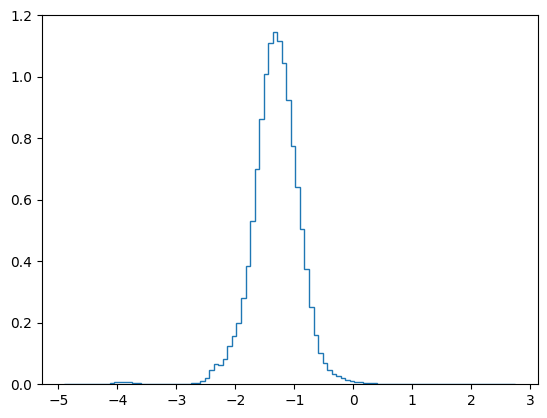

In [19]:
import matplotlib.pyplot as plt

plt.stairs(hists[0], bins[0])

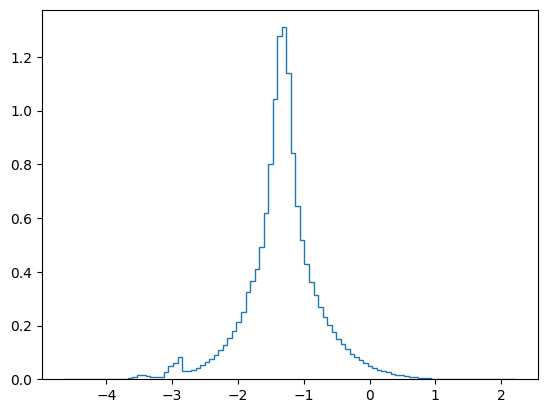

In [20]:
plt.stairs(hists[1], bins[1])

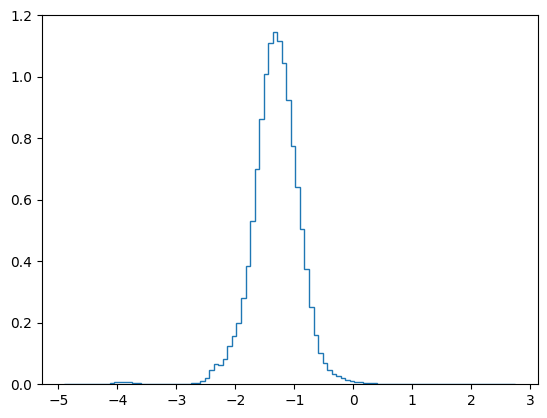

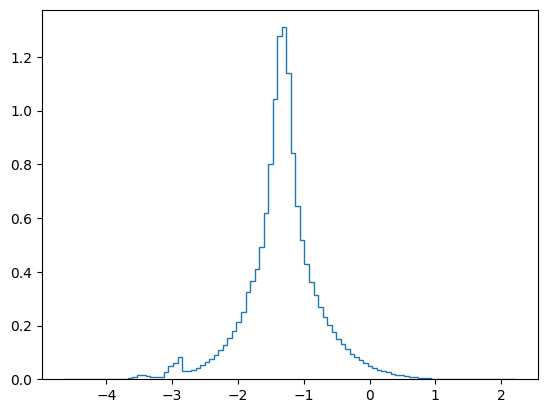

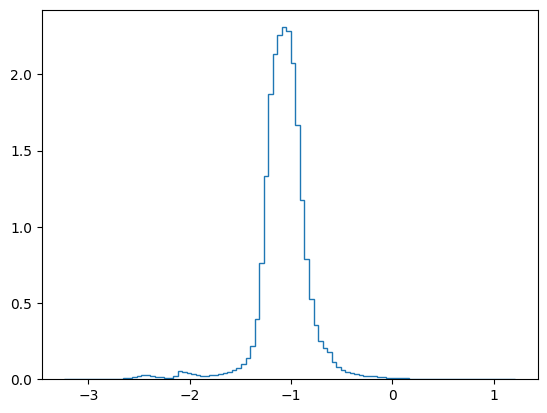

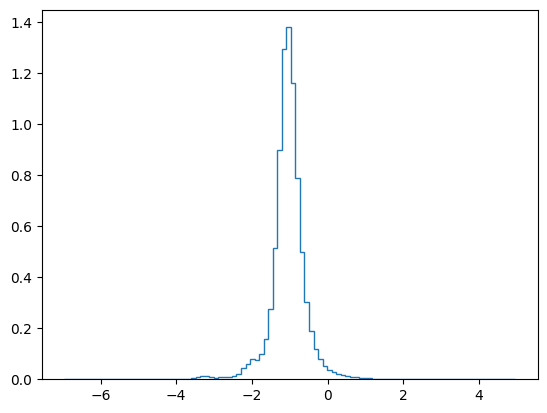

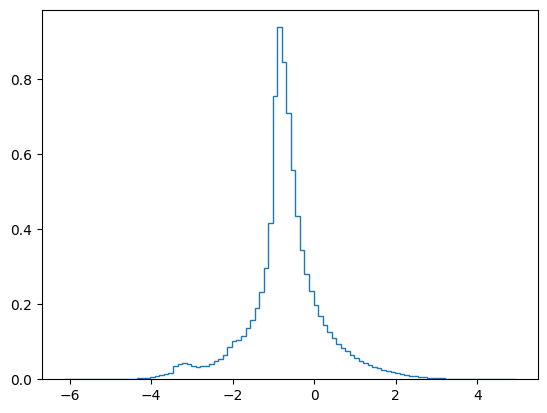

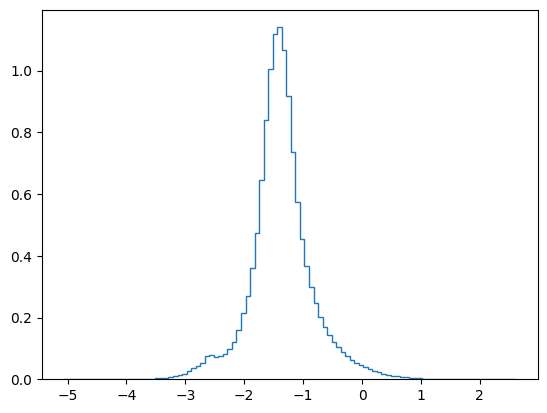

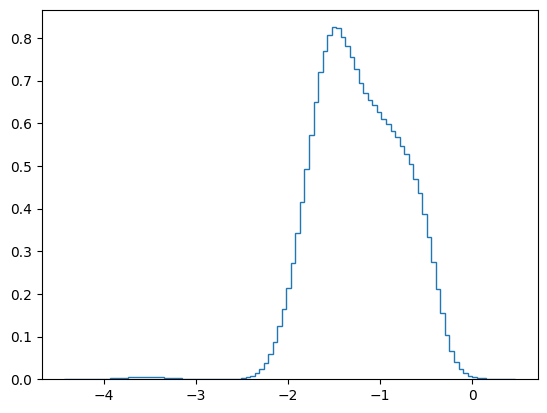

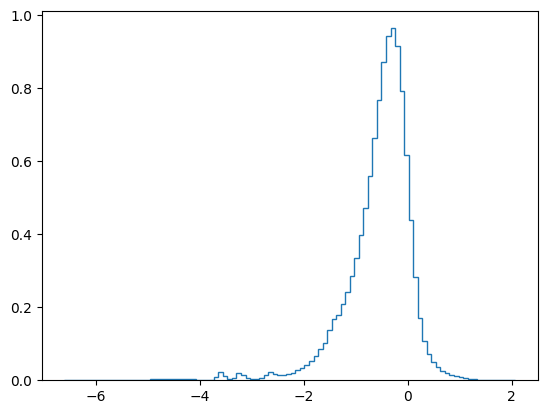

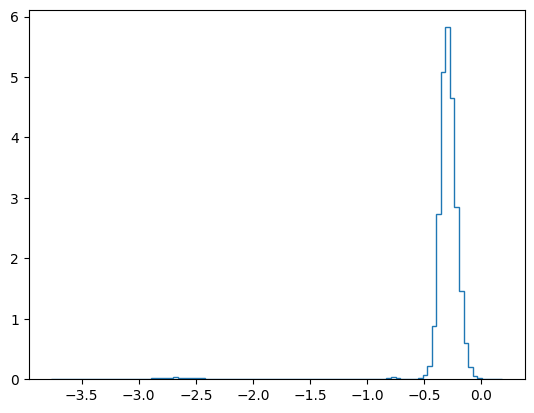

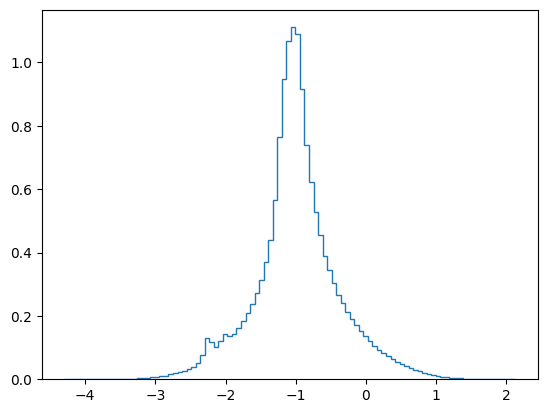

In [21]:
for i in range(10):
    plt.stairs(hists[i], bins[i])
    plt.show()


In [22]:
from distances import JD

JD(torch.tensor(hists[0]), torch.tensor(hists[1]))


tensor(1.2503, dtype=torch.float64)

In [47]:
ds = [(i, j, emd(centers[i], centers[j], hists[i], hists[j])) for i in range(batch.shape[-1]) for j in range(batch.shape[-1]) if i != j]

KeyboardInterrupt: 

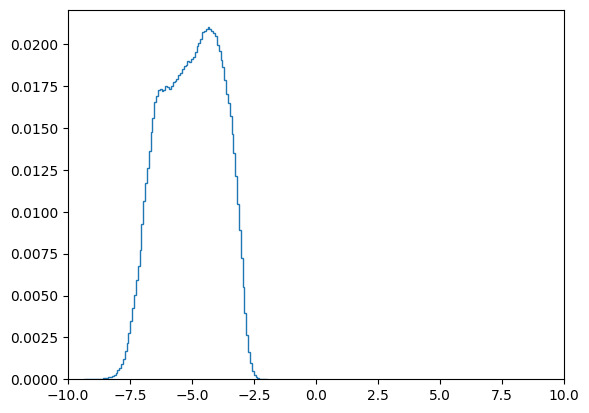

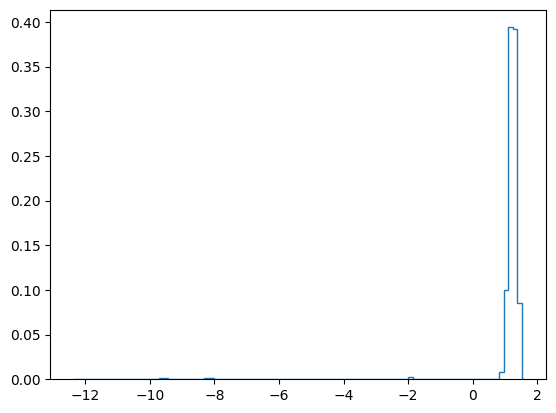

In [49]:
i, j, d = max(ds, key=lambda k: k[-1])
plt.xlim(-10, 10)

plt.stairs(hists[i], bins[i])
plt.show()
plt.stairs(hists[j], bins[j])
plt.show()


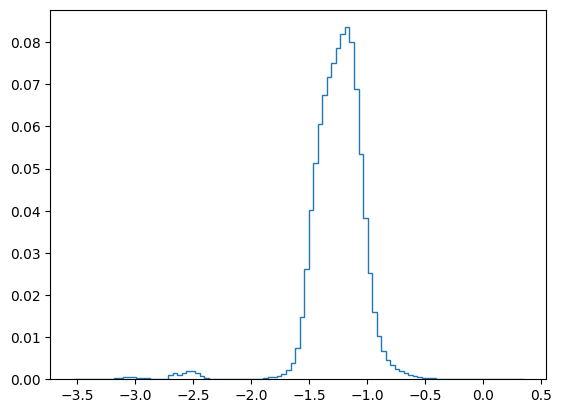

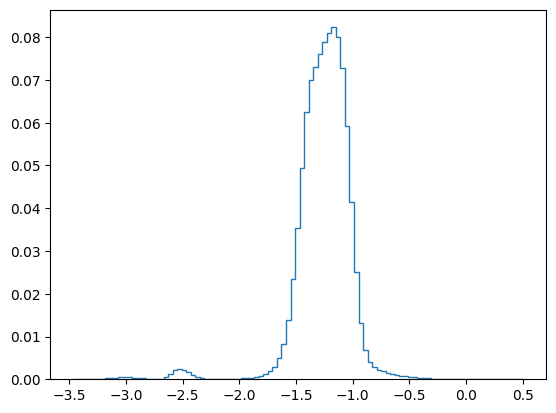

In [50]:
i, j, d = min(ds, key=lambda k: k[-1])
plt.stairs(hists[i], bins[i])
plt.show()

plt.stairs(hists[j], bins[j])
plt.show()